<a href="https://colab.research.google.com/github/szuhow/corona/blob/main/coronary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
!pip install "ray[tune]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.6/29.6 MB 17.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 MB 12.1 MB/s eta 0:00:0000:0100:01


In [1]:

%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import re
import time
import json
import copy
import math
import glob
import torch
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from collections import defaultdict
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models, utils
from torchvision.transforms.functional import to_tensor, to_pil_image
from pytorch_model_summary import summary
from torch.utils.tensorboard import SummaryWriter
import cv2
import ray
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from itertools import product


/opt/miniconda3/envs/ml/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-01-11 13:25:02,871	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-01-11 13:25:03,069	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [14]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'PyTorch is using GPU: {torch.cuda.get_device_name(0)}')
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("PyTorch is using MPS (Metal Performance Shaders)")
else:
    device = torch.device("cpu")
    print("GPU not available, using CPU")

PyTorch is using MPS (Metal Performance Shaders)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# path = '/content/drive/MyDrive/train_voc'
path = '/Users/rafalszulinski/Desktop/developing/IVES/coronary/tensorflow-unet-labelme/datasets/train_voc'

In [3]:
def natural_sort_key(s):
    """
    Function to generate a natural sort key.
    """
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]

In [4]:
image_dir = sorted(glob.glob(os.path.join(path, 'JPEGImages/*')), key=natural_sort_key)
mask_dir = sorted(glob.glob(os.path.join(path, 'SegmentationClassPNG/*')), key=natural_sort_key)

NameError: name 'path' is not defined

In [5]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )


class UNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()

        self.dconv_down1 = double_conv(1, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)

        self.conv_last = nn.Conv2d(64, n_class, 1)


    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)

        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)

        x = self.dconv_down4(x)

        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)

        x = self.dconv_up3(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)

        x = self.dconv_up2(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)

        x = self.dconv_up1(x)

        out = self.conv_last(x)

        return out

In [ ]:
# import logging

# # Set up a basic logger
# logging.basicConfig(level=logging.INFO)
# logger = logging.getLogger(__name__)

# def double_conv(in_channels, out_channels):
#     return nn.Sequential(
#         nn.Conv2d(in_channels, out_channels, 3, padding=1),
#         nn.ReLU(inplace=True),
#         nn.Conv2d(out_channels, out_channels, 3, padding=1),
#         nn.ReLU(inplace=True)
#     )


# class UNet(nn.Module):

#     def __init__(self, n_class):
#         super().__init__()

#         self.dconv_down1 = double_conv(1, 64)
#         self.dconv_down2 = double_conv(64, 128)
#         self.dconv_down3 = double_conv(128, 256)
#         self.dconv_down4 = double_conv(256, 512)

#         self.maxpool = nn.MaxPool2d(2)
#         self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

#         self.dconv_up3 = double_conv(256 + 512, 256)
#         self.dconv_up2 = double_conv(128 + 256, 128)
#         self.dconv_up1 = double_conv(128 + 64, 64)

#         self.conv_last = nn.Conv2d(64, n_class, 1)


#     def forward(self, x):
#         print(f"Input shape: {x.shape}")  # Log input shape
#         conv1 = self.dconv_down1(x)
#         print(f"conv1 shape: {conv1.shape}")  # Log conv1 shape
#         x = self.maxpool(conv1)
#         print(f"maxpool1 shape: {x.shape}")  # Log maxpool1 shape

#         conv2 = self.dconv_down2(x)
#         print(f"conv2 shape: {conv2.shape}")  # Log conv2 shape
#         x = self.maxpool(conv2)
#         print(f"maxpool2 shape: {x.shape}")  # Log maxpool2 shape

#         conv3 = self.dconv_down3(x)
#         print(f"conv3 shape: {conv3.shape}")  # Log conv3 shape
#         x = self.maxpool(conv3)
#         print(f"maxpool3 shape: {x.shape}")  # Log maxpool3 shape

#         x = self.dconv_down4(x)
#         print(f"dconv_down4 shape: {x.shape}")  # Log dconv_down4 shape

#         x = self.upsample(x)
#         print(f"upsample1 shape: {x.shape}")  # Log upsample1 shape
#         x = torch.cat([x, conv3], dim=1)
#         print(f"cat1 shape: {x.shape}")  # Log cat1 shape

#         x = self.dconv_up3(x)
#         print(f"dconv_up3 shape: {x.shape}")  # Log dconv_up3 shape
#         x = self.upsample(x)
#         print(f"upsample2 shape: {x.shape}")  # Log upsample2 shape
#         x = torch.cat([x, conv2], dim=1)
#         print(f"cat2 shape: {x.shape}")  # Log cat2 shape

#         x = self.dconv_up2(x)
#         print(f"dconv_up2 shape: {x.shape}")  # Log dconv_up2 shape
#         x = self.upsample(x)
#         print(f"upsample3 shape: {x.shape}")  # Log upsample3 shape
#         x = torch.cat([x, conv1], dim=1)

#         x = self.dconv_up1(x)

#         out = self.conv_last(x)

#         return out

In [6]:
len_data = len(image_dir)
train_size = 0.8

train_image_paths = image_dir[:int(len_data*train_size)]
test_image_paths = image_dir[int(len_data*train_size):]

train_mask_paths = mask_dir[:int(len_data*train_size)]
test_mask_paths = mask_dir[int(len_data*train_size):]

NameError: name 'image_dir' is not defined

In [7]:
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class CoronaryDataset(Dataset):
    def __init__(self, image_paths, target_paths, train=True):
        self.image_paths = image_paths
        self.target_paths = target_paths
        self.transforms = transforms.Compose([
            transforms.Grayscale(num_output_channels=3),  # Konwersja obrazu w skali szarości na obraz RGB
            transforms.Resize((256, 256)),  # Resize to 256x256
            transforms.ToTensor(),
            # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # wartości dla ImageNet
        ])
        self.mask_transforms = transforms.Compose([

            transforms.Resize((256, 256)),  # Resize to 256x256
            transforms.ToTensor()
        ])

    def __getitem__(self, index):
        # Load image and mask
        image = Image.open(self.image_paths[index]).convert('RGB')  # Ensure RGB mode
        mask = Image.open(self.target_paths[index]).convert('RGB')  # Ensure RGB mode

        # Extract red channel from mask and copy to green and blue
        mask_np = np.array(mask)  # Convert to NumPy array
        red_channel = mask_np[:, :, 0]  # Extract red channel
        mask_np[:, :, 1] = red_channel  # Copy to green channel
        mask_np[:, :, 2] = red_channel  # Copy to blue channel

        # Convert back to PIL image and apply transformations
        updated_mask = Image.fromarray(mask_np)
        t_image = self.transforms(image)
        t_mask = self.mask_transforms(updated_mask)

        # Convert mask to single channel
        t_mask = t_mask[0, :, :].unsqueeze(0)  # Use only the red channel and add channel dimension

        # Binarize the mask if needed (e.g., threshold)
        t_mask = (t_mask > 0).type(torch.float32)
        grayscale = transforms.Grayscale(num_output_channels=1)

        t_image = grayscale(t_image)
        t_mask = grayscale(t_mask)
        return [t_image, t_mask]

    def __len__(self):
        return len(self.image_paths)

In [8]:
batch_size = 8

train_dataset = CoronaryDataset(train_image_paths, train_mask_paths, train=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

test_dataset = CoronaryDataset(test_image_paths, test_mask_paths, train=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

image_datasets = {
    'train': train_dataset, 'val': test_dataset
}
dataloaders = {
    'train': train_loader,
    'val': test_loader
}

dataset_sizes = {
    x: len(image_datasets[x]) for x in image_datasets.keys()
}

NameError: name 'train_image_paths' is not defined

In [9]:
# # image = cv2.imread(train_mask_paths[0], cv2.IMREAD_UNCHANGED)  # Load with transparency if available

# # # Check if the image has an alpha channel
# # has_alpha = image.shape[2] == 4

# # Split into channels
# channels = cv2.split(np.array(mask))  # Returns a list of channels (B, G, R, [A])

# # Visualize the channels
# channel_names = ["Blue", "Green", "Red"] + (["Alpha"] if has_alpha else [])
# plt.figure(figsize=(10, 5))
# for i, channel in enumerate(channels):
#     plt.subplot(1, len(channels), i + 1)
#     plt.title(channel_names[i])
#     plt.imshow(channel, cmap='gray')
#     plt.axis('off')

# plt.show()

In [10]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Przyjmijmy, że masz swój data loader, np.:
# dataloader = dataloaders['train']  # lub po prostu train_loader

# Pobierz iterator z data loadera
dataiter = iter(dataloaders['train'])

# Pobierz jeden batch danych (obrazy i maski)
images, masks = next(dataiter)

# Wybierz pierwszy obraz i maskę z batcha
sample_image = images[0]
sample_mask = masks[0]

# Jeśli chcesz zobaczyć kształty tensora
print(f"Sample image shape: {sample_image.shape}")  # np. [3, 256, 256]
print(f"Sample mask shape: {sample_mask.shape}")    # np. [1, 256, 256]

# Przekształć tensory do formatu numpy i przenieś kanały
sample_image_np = sample_image.cpu().numpy().transpose((1, 2, 0))
sample_mask_np = sample_mask.cpu().numpy().squeeze()

# # Jeśli obrazy były normalizowane, cofnij normalizację dla wizualizacji
# mean = np.array([0.485, 0.456, 0.406])  # wartości użyte w normalizacji
# std = np.array([0.229, 0.224, 0.225])
# sample_image_np = std * sample_image_np + mean
# sample_image_np = np.clip(sample_image_np, 0, 1)

# Wyświetl obraz i maskę
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(sample_image_np, cmap='gray')
plt.title('Przykładowy obraz')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(sample_mask_np, cmap='gray')
plt.title('Przykładowa maska')
plt.axis('off')

plt.show()

NameError: name 'dataloaders' is not defined

In [11]:
print(summary(UNet(1), torch.zeros((16, 1, 256,256)), show_input=True))

---------------------------------------------------------------------------
      Layer (type)             Input Shape         Param #     Tr. Param #
          Conv2d-1       [16, 1, 256, 256]             640             640
            ReLU-2      [16, 64, 256, 256]               0               0
          Conv2d-3      [16, 64, 256, 256]          36,928          36,928
            ReLU-4      [16, 64, 256, 256]               0               0
       MaxPool2d-5      [16, 64, 256, 256]               0               0
          Conv2d-6      [16, 64, 128, 128]          73,856          73,856
            ReLU-7     [16, 128, 128, 128]               0               0
          Conv2d-8     [16, 128, 128, 128]         147,584         147,584
            ReLU-9     [16, 128, 128, 128]               0               0
         Conv2d-10       [16, 128, 64, 64]         295,168         295,168
           ReLU-11       [16, 256, 64, 64]               0               0
         Conv2d-12      

In [ ]:
parameters = dict(
    lr = [1e-4, 1e-3],
    batch_size = [16, 32],
    shuffle = [True, False], 
    epochs = [50, 100, 200],
    optimizer = [optim.SGD],
)


0.0001 16 True 4 50 <class 'torch.optim.sgd.SGD'>
0.0001 16 True 4 100 <class 'torch.optim.sgd.SGD'>
0.0001 16 True 4 200 <class 'torch.optim.sgd.SGD'>
0.0001 16 False 4 50 <class 'torch.optim.sgd.SGD'>
0.0001 16 False 4 100 <class 'torch.optim.sgd.SGD'>
0.0001 16 False 4 200 <class 'torch.optim.sgd.SGD'>
0.0001 32 True 4 50 <class 'torch.optim.sgd.SGD'>
0.0001 32 True 4 100 <class 'torch.optim.sgd.SGD'>
0.0001 32 True 4 200 <class 'torch.optim.sgd.SGD'>
0.0001 32 False 4 50 <class 'torch.optim.sgd.SGD'>
0.0001 32 False 4 100 <class 'torch.optim.sgd.SGD'>
0.0001 32 False 4 200 <class 'torch.optim.sgd.SGD'>
0.001 16 True 4 50 <class 'torch.optim.sgd.SGD'>
0.001 16 True 4 100 <class 'torch.optim.sgd.SGD'>
0.001 16 True 4 200 <class 'torch.optim.sgd.SGD'>
0.001 16 False 4 50 <class 'torch.optim.sgd.SGD'>
0.001 16 False 4 100 <class 'torch.optim.sgd.SGD'>
0.001 16 False 4 200 <class 'torch.optim.sgd.SGD'>
0.001 32 True 4 50 <class 'torch.optim.sgd.SGD'>
0.001 32 True 4 100 <class 'torch.op

In [12]:



# def dice_loss(pred, target, smooth=1e-5):
#     """Calculate Dice loss for binary segmentation."""
#     intersection = (pred * target).sum()
#     return 1 - (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

model = UNet(1)  # Replace with your model


def dice_loss(pred, target, smooth=1e-5):
    pred = pred.contiguous()
    target = target.contiguous()

    intersection = (pred * target).sum(dim=2).sum(dim=2)

    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))

    return loss.mean()

def calc_loss(pred, target, metrics, bce_weight=0.1):
    """Calculate combined BCE and Dice loss with metrics tracking."""
    bce = F.binary_cross_entropy_with_logits(pred, target)
    pred_sigmoid = torch.sigmoid(pred)
    dice = dice_loss(pred_sigmoid, target)

    loss = bce * bce_weight + dice * (1 - bce_weight)

    # Update metrics (detach to prevent gradient tracking)
    with torch.no_grad():
        metrics['bce'] += bce.item() * target.size(0)
        metrics['dice'] += dice.item() * target.size(0)
        metrics['loss'] += loss.item() * target.size(0)

    return loss

def print_metrics(metrics, epoch_samples, phase):
    """Print formatted metrics for the current phase."""
    outputs = [f"{k}: {metrics[k] / epoch_samples:.4f}" for k in metrics.keys()]
    print(f"{phase}: {', '.join(outputs)}")

def train_model(model, dataloaders, optimizer, scheduler, device, num_epochs=3):
    """Comprehensive model training function with validation."""
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    
    # print(lr, batch_size, shuffle, workers, epochs, optimizer)
    for epoch in range(num_epochs):
        
        

        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        since = time.time()

        # Training and validation phases
        for phase in ['train', 'val']:
            # Adjust learning rate and model mode
            if phase == 'train':
                scheduler.step()
                model.train()
                print("LR:", optimizer.param_groups[0]['lr'])
            else:
                model.eval()

            # Reset metrics for current phase
            metrics = defaultdict(float)
            epoch_samples = 0

            # Disable gradient computation for validation
            with torch.set_grad_enabled(phase == 'train'):
                for i, (inputs, labels) in enumerate(tqdm(dataloaders[phase], desc=f'{phase} Epoch {epoch}')):
                    inputs, labels = inputs.to(device), labels.to(device)
                    optimizer.zero_grad()

                    # Forward pass
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics)

                    # loss = loss / accumulation_steps  # Scale loss to account for accumulation
                    # loss.backward()

                    # if (i + 1) % accumulation_steps == 0:  # Update weights every accumulation_steps
                    #     optimizer.step()

                    # Backward pass and optimization
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # Update statistics
                    epoch_samples += inputs.size(0)
                    # print('Loss/{}'.format(phase), loss.item(), epoch * len(dataloaders[phase]) + i)
                    writer.add_scalar('Loss/{}'.format(phase), loss.item(), epoch * len(dataloaders[phase]) + i)  
                    writer.add_scalar('BCE/{}'.format(phase), metrics['bce'] / (i + 1) , epoch * len(dataloaders[phase]) + i)  # Log BCE loss
                    writer.add_scalar('Dice/{}'.format(phase), metrics['dice'] / (i + 1) , epoch * len(dataloaders[phase]) + i)  # Log Dice loss

                # writer.add_histogram('model/conv1/weight', model.conv1.weight, epoch)
                # writer.add_histogram('model/conv1/bias', model.conv1.bias, epoch)

                print("Starting parameter inspection...")
                for name, param in model.named_parameters():
                    print(f"Inspecting parameter: {name}")
                    if param is not None:
                        print(name, param.data)
                        writer.add_histogram(name, param, epoch)
                    else:
                        print(f"Parameter {name} is None")
                print("Finished parameter inspection.")
            # Print and track phase metrics
            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples
            writer.add_scalar('Loss/{}'.format(phase), epoch_loss, epoch)  # Log loss
            # Save best model
            if phase == 'val' and epoch_loss < best_loss:
                print("Saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

            for name, param in model.named_parameters():
                print(name, param.data)
                writer.add_histogram(name, param, epoch)

        # Print epoch time
        time_elapsed = time.time() - since
        print(f'{time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    print(f'Best val loss: {best_loss:.4f}')
    model.load_state_dict(best_model_wts)
    # writer.flush()
    writer.close()  
    return model

def setup_training(model, learning_rate=0.001, step_size=25, gamma=0.1):
    """Setup optimizer and learning rate scheduler."""
    model = model.to(device)
    

    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    comment = f'LR_{scheduler.get_last_lr()[0]} batch_size_{batch_size} gamma_{gamma} step_size_{step_size} optimizer_Adam'
    writer = SummaryWriter(comment=comment)

    images, masks = next(iter(train_loader))
    grid = utils.make_grid(images)
    writer.add_images('images', images)
    writer.add_images('masks', masks)
    writer.add_graph(UNet(1), images)
    return model, optimizer, scheduler, device

def tune_model():
    for lr, batch_size, shuffle, epochs, optimizer in product(*parameters.values()):
        model = UNet(1)
        model, optimizer, scheduler, device = setup_training(model, config['lr'])
        model = train_model(model, dataloaders, optimizer, scheduler, device, config['epochs'])
        return model

    return model


In [13]:
 # Prepare training components
model, optimizer, scheduler, device = setup_training(model)

# Prepare dataloaders for train and validation
# Train the model
trained_model = train_model(
    model,
    dataloaders,
    optimizer,
    scheduler,
    device
)

NameError: name 'device' is not defined

In [56]:

# Funkcja do obliczania straty Dice
def dice_loss(pred, target, smooth=1e-5):
    pred = pred.contiguous()
    target = target.contiguous()
    intersection = (pred * target).sum(dim=2).sum(dim=2)
    loss = 1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth))
    return loss.mean()

# Funkcja do obliczania straty łączonej BCE i Dice
def calc_loss(pred, target, metrics, bce_weight=0.1):
    bce = F.binary_cross_entropy_with_logits(pred, target)
    pred_sigmoid = torch.sigmoid(pred)
    dice = dice_loss(pred_sigmoid, target)
    loss = bce * bce_weight + dice * (1 - bce_weight)
    with torch.no_grad():
        metrics['bce'] += bce.item() * target.size(0)
        metrics['dice'] += dice.item() * target.size(0)
        metrics['loss'] += loss.item() * target.size(0)
    return loss

# Funkcja do drukowania metryk
def print_metrics(metrics, epoch_samples, phase):
    outputs = [f"{k}: {metrics[k] / epoch_samples:.4f}" for k in metrics.keys()]
    print(f"{phase}: {', '.join(outputs)}")

# Funkcja treningowa
def train_model(model, dataloaders, optimizer, scheduler, device, writer, num_epochs, bce_weight):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        since = time.time()

        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()
                print("LR:", optimizer.param_groups[0]['lr'])
            else:
                model.eval()

            metrics = defaultdict(float)
            epoch_samples = 0

            with torch.set_grad_enabled(phase == 'train'):
                for i, (inputs, labels) in enumerate(tqdm(dataloaders[phase], desc=f'{phase} Epoch {epoch}')):
                    inputs, labels = inputs.to(device), labels.to(device)
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics, bce_weight)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    epoch_samples += inputs.size(0)

                    writer.add_scalar('Batch loss/{}'.format(phase), loss.item(), epoch * len(dataloaders[phase]) + i)
                    writer.add_scalar('Batch BCE/{}'.format(phase), metrics['bce'] / (i + 1), epoch * len(dataloaders[phase]) + i)
                    writer.add_scalar('Batch Dice/{}'.format(phase), metrics['dice'] / (i + 1), epoch * len(dataloaders[phase]) + i)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples
            epoch_dice = metrics['dice'] / epoch_samples
            epoch_bce = metrics['bce'] / epoch_samples
            writer.add_scalar('Epoch loss/{}'.format(phase), epoch_loss, epoch)
            writer.add_scalar('Epoch BCE/{}'.format(phase), epoch_bce, epoch)
            writer.add_scalar('Epoch Dice/{}'.format(phase), epoch_dice, epoch)
            
            if phase == 'val' and epoch_loss < best_loss:
                print("Saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

            # for name, param in model.named_parameters():
            #     writer.add_histogram(name, param, epoch)

        time_elapsed = time.time() - since
        print(f'{time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    print(f'Best val loss: {best_loss:.4f}')
    model.load_state_dict(best_model_wts)
    writer.close()
    return model

# Funkcja do konfiguracji treningu
def setup_training(model, config):
    lr = config['lr']
    batch_size = config['batch_size']
    shuffle = config['shuffle']
    epochs = config['epochs']
    optimizer_name = config['optimizer']
    bce_weight = config['bce_weight']
    step_size = 25
    gamma = 0.1

    model = model.to(device)

    if optimizer_name == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    elif optimizer_name == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-5)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer_name}")

    scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    writer = SummaryWriter(comment=f' LR_{lr}_optimizer_{optimizer_name}_batch_size_{batch_size}_gamma_{gamma}_step_size_{step_size}_epochs_{epochs}_bce_weight_{bce_weight}')  
    return model, optimizer, scheduler, device, writer

# Funkcja do tuningu modelu
def tune_model(dataloaders, parameters):
    best_model = None
    best_loss = float('inf')

    for lr, batch_size, shuffle, epochs, optimizer_name, bce_weight in product(*parameters.values()):
        model = UNet(1)
        config = {
            'lr': lr,
            'batch_size': batch_size,
            'shuffle': shuffle,
            'epochs': epochs,
            'optimizer': optimizer_name, 
            'bce_weight': bce_weight
        }
        model, optimizer, scheduler, device, writer = setup_training(model, config)
        model = train_model(model=model, dataloaders=dataloaders, optimizer=optimizer, device=device, scheduler=scheduler, writer=writer, num_epochs=epochs, bce_weight=bce_weight)

        val_loss = evaluate_model(model, dataloaders['val'], device)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model = copy.deepcopy(model)

    return best_model

# Funkcja do oceny modelu
def evaluate_model(model, dataloader, device):
    model.eval()
    metrics = defaultdict(float)
    epoch_samples = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = calc_loss(outputs, labels, metrics)
            epoch_samples += inputs.size(0)

    epoch_loss = metrics['loss'] / epoch_samples
    return epoch_loss

# Przykład użycia
# parameters = {
#     'lr': [1e-4, 1e-3],
#     'batch_size': [16, 32],
#     'shuffle': [True, False],
#     'epochs': [10, 20],
#     'optimizer': ['adam', 'sgd']
# }

parameters = {
    'lr': [1e-4],
    'batch_size': [16],
    'shuffle': [True],
    'epochs': [5],
    'optimizer': ['sgd'],
    'bce_weight': [0.1, 0.9]
}



In [57]:
best_model = tune_model(dataloaders, parameters)

Epoch 0/4
----------
LR: 0.0001


train Epoch 0: 100%|██████████| 70/70 [01:55<00:00,  1.66s/it]


train: bce: 0.7051, dice: 0.9175, loss: 0.8963


val Epoch 0: 100%|██████████| 18/18 [00:08<00:00,  2.10it/s]


val: bce: 0.7041, dice: 0.9195, loss: 0.8980
Saving best model
2m 5s
Epoch 1/4
----------
LR: 0.0001


train Epoch 1: 100%|██████████| 70/70 [01:57<00:00,  1.68s/it]


train: bce: 0.7030, dice: 0.9175, loss: 0.8961


val Epoch 1: 100%|██████████| 18/18 [00:09<00:00,  1.95it/s]


val: bce: 0.7020, dice: 0.9195, loss: 0.8978
Saving best model
2m 7s
Epoch 2/4
----------
LR: 0.0001


train Epoch 2: 100%|██████████| 70/70 [02:03<00:00,  1.77s/it]


train: bce: 0.7009, dice: 0.9176, loss: 0.8959


val Epoch 2: 100%|██████████| 18/18 [00:09<00:00,  1.82it/s]


val: bce: 0.6999, dice: 0.9195, loss: 0.8976
Saving best model
2m 14s
Epoch 3/4
----------
LR: 0.0001


train Epoch 3: 100%|██████████| 70/70 [02:21<00:00,  2.02s/it]


train: bce: 0.6989, dice: 0.9176, loss: 0.8957


val Epoch 3: 100%|██████████| 18/18 [00:10<00:00,  1.68it/s]


val: bce: 0.6978, dice: 0.9195, loss: 0.8974
Saving best model
2m 32s
Epoch 4/4
----------
LR: 0.0001


train Epoch 4: 100%|██████████| 70/70 [02:19<00:00,  2.00s/it]


train: bce: 0.6968, dice: 0.9176, loss: 0.8955


val Epoch 4: 100%|██████████| 18/18 [00:09<00:00,  1.86it/s]


val: bce: 0.6958, dice: 0.9196, loss: 0.8972
Saving best model
2m 29s
Best val loss: 0.8972
Epoch 0/4
----------
LR: 0.0001


train Epoch 0: 100%|██████████| 70/70 [02:21<00:00,  2.03s/it]


train: bce: 0.6445, dice: 0.9181, loss: 0.6718


val Epoch 0: 100%|██████████| 18/18 [00:09<00:00,  1.81it/s]


val: bce: 0.6357, dice: 0.9201, loss: 0.6642
Saving best model
2m 32s
Epoch 1/4
----------
LR: 0.0001


train Epoch 1: 100%|██████████| 70/70 [02:31<00:00,  2.16s/it]


train: bce: 0.6279, dice: 0.9182, loss: 0.6569


val Epoch 1: 100%|██████████| 18/18 [00:09<00:00,  1.97it/s]


val: bce: 0.6198, dice: 0.9202, loss: 0.6498
Saving best model
2m 40s
Epoch 2/4
----------
LR: 0.0001


train Epoch 2: 100%|██████████| 70/70 [02:16<00:00,  1.95s/it]


train: bce: 0.6129, dice: 0.9184, loss: 0.6435


val Epoch 2: 100%|██████████| 18/18 [00:09<00:00,  1.93it/s]


val: bce: 0.6055, dice: 0.9204, loss: 0.6370
Saving best model
2m 26s
Epoch 3/4
----------
LR: 0.0001


train Epoch 3: 100%|██████████| 70/70 [02:14<00:00,  1.92s/it]


train: bce: 0.5991, dice: 0.9185, loss: 0.6310


val Epoch 3: 100%|██████████| 18/18 [00:09<00:00,  1.88it/s]


val: bce: 0.5919, dice: 0.9205, loss: 0.6248
Saving best model
2m 24s
Epoch 4/4
----------
LR: 0.0001


train Epoch 4: 100%|██████████| 70/70 [02:04<00:00,  1.78s/it]


train: bce: 0.5859, dice: 0.9187, loss: 0.6192


val Epoch 4: 100%|██████████| 18/18 [00:10<00:00,  1.79it/s]


val: bce: 0.5791, dice: 0.9207, loss: 0.6132
Saving best model
2m 14s
Best val loss: 0.6132


In [ ]:
torch.save(trained_model.state_dict(), "colab-2.pth")

In [ ]:
torch.cuda.empty_cache()

--------------------------------------------------------------------------------------


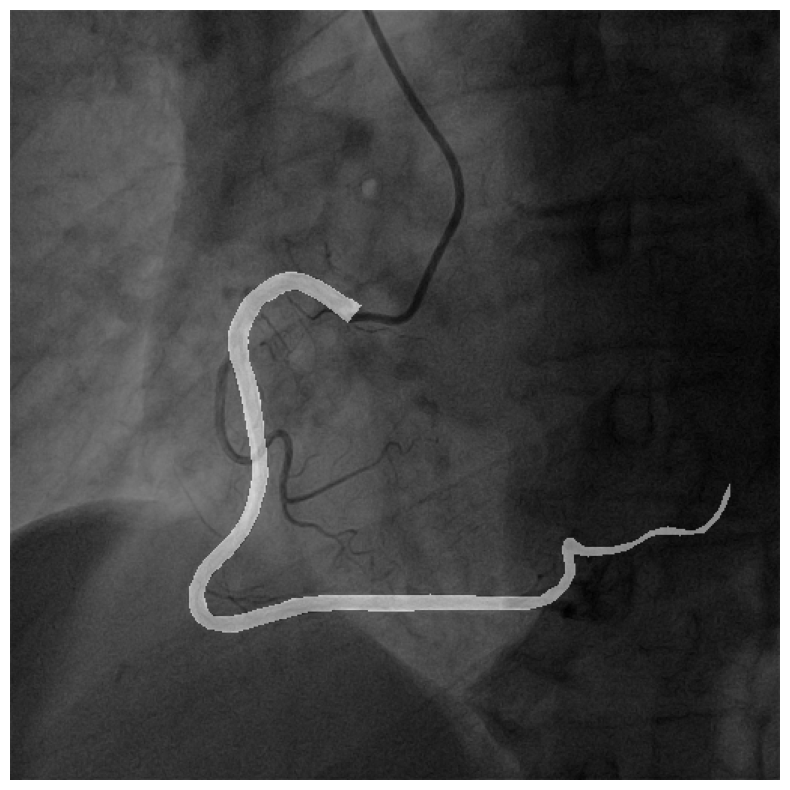

In [ ]:
# show first image
image, mask = train_dataset[0]



# Convert the image and mask to NumPy arrays
image_np = image.squeeze().numpy()
mask_np = mask.squeeze().numpy()
# image_np
# # Create a figure and axis
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# # Display the image
ax.imshow(image_np, cmap='gray')

# # Overlay the mask with some transparency
ax.imshow(mask_np, cmap='gray', alpha=0.5)  # 'jet' colormap for the mask

# # Hide the axis
ax.axis('off')

# # Show the plot
plt.show()

In [ ]:
def reverse_transform(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    inp = (inp * 255).astype(np.uint8)

    return inp

In [ ]:
# from collections import defaultdict
# import torch.nn.functional as F
# def dice_loss(pred, target, smooth = 1.):
#     pred = pred.contiguous()
#     target = target.contiguous()

#     intersection = (pred * target).sum(dim=2).sum(dim=2)

#     loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))

#     return loss.mean()
# def calc_loss(pred, target, metrics, bce_weight=0.5):
#     bce = F.binary_cross_entropy_with_logits(pred, target)

#     pred = F.sigmoid(pred)
#     dice = dice_loss(pred, target)

#     loss = bce * bce_weight + dice * (1 - bce_weight)

#     metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
#     metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
#     metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

#     return loss

# def print_metrics(metrics, epoch_samples, phase):
#     outputs = []
#     for k in metrics.keys():
#         outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))

#     print("{}: {}".format(phase, ", ".join(outputs)))

# def train_model(model, optimizer, scheduler, num_epochs=25):
#     best_model_wts = copy.deepcopy(model.state_dict())
#     best_loss = 1e10

#     for epoch in range(num_epochs):
#         print('Epoch {}/{}'.format(epoch, num_epochs - 1))
#         print('-' * 10)

#         since = time.time()

#         # Each epoch has a training and validation phase
#         for phase in ['train', 'val']:
#             if phase == 'train':
#                 scheduler.step()
#                 for param_group in optimizer.param_groups:
#                     print("LR", param_group['lr'])

#                 model.train()  # Set model to training mode
#             else:
#                 model.eval()   # Set model to evaluate mode

#             metrics = defaultdict(float)
#             epoch_samples = 0

#             for inputs, labels in dataloaders[phase]:
#                 inputs = inputs.to(device)
#                 labels = labels.to(device)

#                 # zero the parameter gradients
#                 optimizer.zero_grad()

#                 # forward
#                 # track history if only in train
#                 with torch.set_grad_enabled(phase == 'train'):
#                     outputs = model(inputs)
#                     loss = calc_loss(outputs, labels, metrics)

#                     # backward + optimize only if in training phase
#                     if phase == 'train':
#                         loss.backward()
#                         optimizer.step()

#                 # statistics
#                 epoch_samples += inputs.size(0)

#             print_metrics(metrics, epoch_samples, phase)
#             epoch_loss = metrics['loss'] / epoch_samples

#             # deep copy the model
#             if phase == 'val' and epoch_loss < best_loss:
#                 print("saving best model")
#                 best_loss = epoch_loss
#                 best_model_wts = copy.deepcopy(model.state_dict())

#         time_elapsed = time.time() - since
#         print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
#     print('Best val loss: {:4f}'.format(best_loss))

#     # load best model weights
#     model.load_state_dict(best_model_wts)
#     return model


In [ ]:
# import torch
# import torch.optim as optim
# from torch.optim import lr_scheduler
# import time
# import copy

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(device)

# num_class = 1

# model = UNet(num_class).to(device)

# # Observe that all parameters are being optimized
# optimizer_ft = optim.Adam(model.parameters(), lr=1e-4)

# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=25, gamma=0.1)

# model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=40)

cuda:0
Epoch 0/39
----------
LR 0.0001


KeyboardInterrupt: 

In [ ]:
def set_memory_management():
    # Configure PyTorch CUDA memory allocation
    torch.cuda.empty_cache()
    if torch.cuda.is_available():
        torch.backends.cudnn.benchmark = True
        torch.backends.cudnn.deterministic = True
set_memory_management()

In [ ]:
model.load_state_dict(torch.load("colab-2.pth"))
model.eval()

# Example inference
with torch.no_grad():
    sample_input = torch.rand(1, 1, 128, 128).to(device)
    output = model(sample_input)
    print(output.shape)

torch.Size([1, 1, 128, 128])


<ipython-input-14-222b3d2473b9>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("colab-2.pth"))


In [12]:
image_path = "/Users/rafalszulinski/Desktop/developing/IVES/coronary/tensorflow-unet-labelme/datasets/train_voc/JPEGImages/391.jpg"  # Replace with your image file path
#image_path = "/content/colab.jpg"  # Replace with your image file path

image = Image.open(image_path).convert('L')  # Convert to grayscale if needed

# Step 2: Preprocess the image
transform = transforms.Compose([
   # transforms.Resize((256, 256)),  # Resize to the model's input size
    transforms.ToTensor(),         # Convert to a PyTorch tensor
    # transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]
])
input_tensor = transform(image).unsqueeze(0)  # Add batch dimension

In [ ]:
model.load_state_dict(torch.load("best_model_epoch_9_loss_0.7575.pth"))  # Load trained weights
model.eval()  # Set to evaluation mode


# Step 4: Run inference
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
input_tensor = input_tensor.to(device)
model = model.to(device)

with torch.no_grad():
    output = model(input_tensor)

# Step 5: Process the output
output = torch.sigmoid(output)  # Apply sigmoid if binary segmentation
output_image = output.squeeze().cpu().numpy()  # Convert back to numpy for visualization
output_image = (output_image - output_image.min()) / (output_image.max() - output_image.min()) * 255
output_image = output_image.astype('uint8')
print("Output min:", output_image.min())
print("Output max:", output_image.max())
print("Output mean:", output_image.mean())
# Visualize the output (optional)
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("Input Image")
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Model Output")
plt.imshow(output_image,cmap='gray')
plt.axis('off')

plt.show()

/var/folders/gp/j593vlkj0jjbz68g1hsn82wh0000gn/T/ipykernel_43165/2846670472.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/Users/rafa

RuntimeError: Error(s) in loading state_dict for UNet:
	Missing key(s) in state_dict: "dconv_down1.0.weight", "dconv_down1.0.bias", "dconv_down1.2.weight", "dconv_down1.2.bias", "dconv_down2.0.weight", "dconv_down2.0.bias", "dconv_down2.2.weight", "dconv_down2.2.bias", "dconv_down3.0.weight", "dconv_down3.0.bias", "dconv_down3.2.weight", "dconv_down3.2.bias", "dconv_down4.0.weight", "dconv_down4.0.bias", "dconv_down4.2.weight", "dconv_down4.2.bias", "dconv_up3.0.weight", "dconv_up3.0.bias", "dconv_up3.2.weight", "dconv_up3.2.bias", "dconv_up2.0.weight", "dconv_up2.0.bias", "dconv_up2.2.weight", "dconv_up2.2.bias", "dconv_up1.0.weight", "dconv_up1.0.bias", "dconv_up1.2.weight", "dconv_up1.2.bias", "conv_last.weight", "conv_last.bias". 
	Unexpected key(s) in state_dict: "epoch", "model_state_dict", "optimizer_state_dict", "loss". 

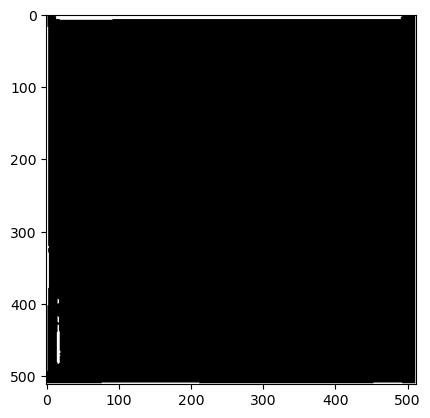

In [18]:
plt.imshow((output_image > 0).astype(np.uint8), cmap='gray')

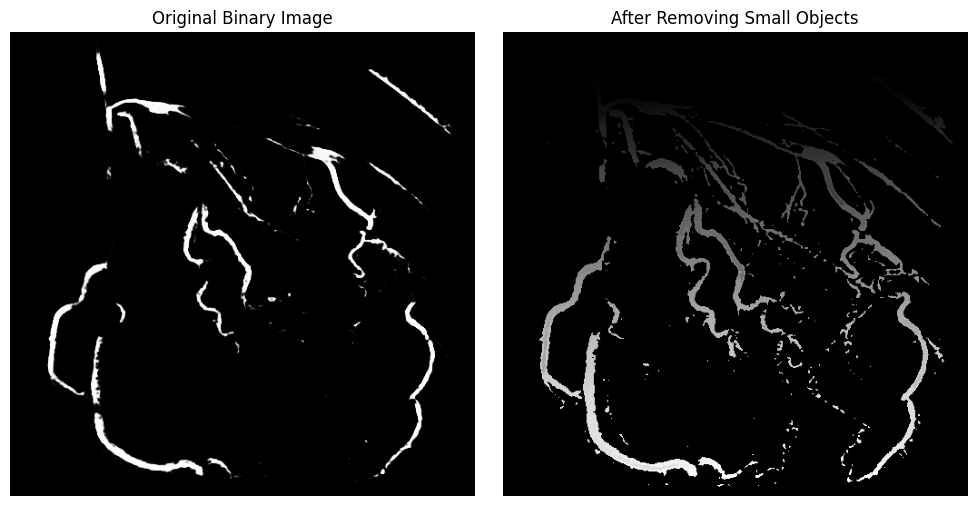

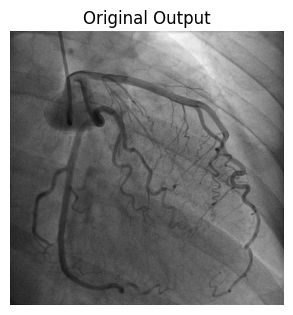

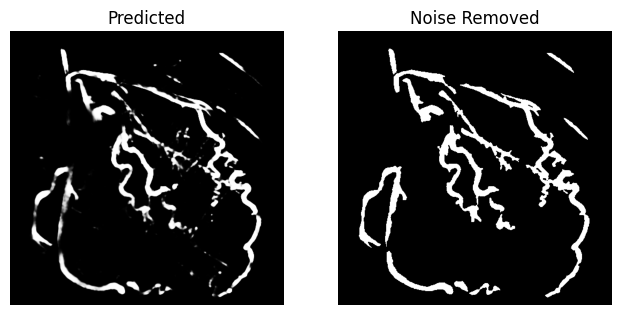

In [ ]:


import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from skimage import morphology

# Load your model and set it to evaluation mode
# model = ...
# model.load_state_dict(torch.load("best_model.pth"))
# model.eval()

# Load and preprocess the input image
# image_path = ...
# image = Image.open(image_path).convert('L')
# transform = ...
# input_tensor = transform(image).unsqueeze(0)
# device = ...
# input_tensor = input_tensor.to(device)
# model = model.to(device)

# Perform inference and get the model output
# with torch.no_grad():
#    output = model(input_tensor)
# output = torch.sigmoid(output)
# output_image = output.squeeze().cpu().numpy()
# output_image = (output_image - output_image.min()) / (output_image.max() - output_image.min()) * 255
# output_image = output_image.astype('uint8')

# --- Noise Removal and Object Filling ---
image_np = np.array(output_image)
# 1. Thresholding (to create a binary mask)
threshold = 20  # Adjust this value as needed
binary_mask = (image_np > threshold)

# 2. Remove small objects
min_size = 200  # Adjust this value to control the size of objects to remove
cleaned_mask = morphology.remove_small_objects(binary_mask, min_size=min_size)

# 3. Fill holes in the remaining objects
filled_mask = morphology.remove_small_holes(cleaned_mask, area_threshold=min_size)

# --- Display Results ---

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Original Output")
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 2)
plt.title("Predicted")
plt.imshow(output_image, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Noise Removed")
plt.imshow(cleaned_mask, cmap='gray')
plt.axis('off')

# plt.subplot(1, 3, 3)
# plt.title("Objects Filled")
# plt.imshow(filled_mask, cmap='gray')
# plt.axis('off')

plt.show()

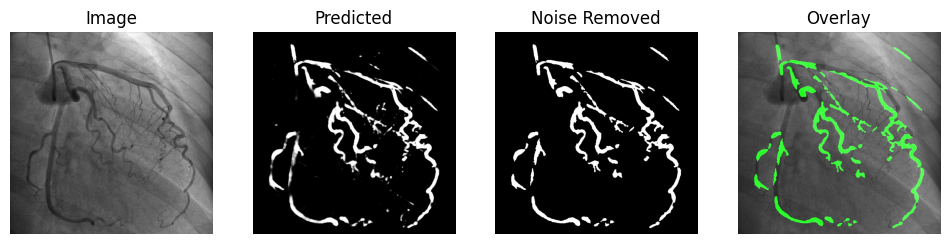

In [ ]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from skimage import morphology

# ... (Your existing code for loading model, preprocessing, and inference) ...

# --- Noise Removal and Object Filling ---
# 1. Thresholding (to create a binary mask)
threshold = 128  # Adjust this value as needed
binary_mask = (output_image > threshold)
# Convert the PIL Image to a NumPy array

image_original = np.array(image)
image_np = np.array(binary_mask)

# 2. Remove small objects
min_size = 50  # Adjust this value to control the size of objects to remove
cleaned_mask = morphology.remove_small_objects(image_np, min_size=min_size)

# 3. Fill holes in the remaining objects
filled_mask = morphology.remove_small_holes(cleaned_mask, area_threshold=min_size)

# --- Overlay cleaned_mask on the original image ---
# Create a color image for overlay (RGB)

from skimage.transform import resize
cleaned_mask_resized = resize(cleaned_mask, (image_original.shape[0], image_original.shape[1]))
overlay_image = np.zeros((image_original.shape[0], image_original.shape[1], 3), dtype=np.uint8)

for i in range(3):
    overlay_image[:, :, i] = image_original

# Set pixels where cleaned_mask is True to a different color (e.g., green)
overlay_image[cleaned_mask_resized, 1] = 255  # Green channel (adjust color as needed)

# --- Display Results ---
plt.figure(figsize=(12, 4))
plt.subplot(1, 4, 1)
plt.title("Image")
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.title("Predicted")
plt.imshow(output_image, cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.title("Noise Removed")
plt.imshow(cleaned_mask, cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.title("Overlay")
plt.imshow(overlay_image)
plt.axis('off')

plt.show()